<h1>computational graphs</h1>

In [1]:
from casadi import *

In [2]:
x = MX.sym('x',2); # states
u = MX.sym('u'); #controls

# van der pol oscillator system (nonlinear ODE)
ode = vertcat((1 - x[1]**2)*x[0] - x[1] + u, x[0])

In [3]:
f = Function('f',[x,u],[ode])

In [4]:
f([0.2,0.8],0.1)

DM([-0.628, 0.2])

<h1>time integration method</h1>

In [5]:
T = 10 # time horizon
N = 20 # number of control intervals

In [6]:
# integrator to discretize the system
dae = {'x':x, 'p':u, 'ode':f(x,u)}
intg = integrator('intg', 'rk', dae, {'tf':T/N, 'number_of_finite_elements':4, 'simplify':True})

CasADi - 2023-10-22 01:05:45 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


In [7]:
res = intg(x0=x,p=u) #evaluate with symbols
x_next = res['xf'] 

In [8]:
# Simplify API to (x,u)->(x_next)
F = Function('F',[x,u],[x_next])

In [9]:
F([0,1],0), F([0.1,0.9],0.1)

(DM([-0.494017, 0.876098]), DM([-0.307745, 0.849043]))

<h1>concept from functional programming</h1>

In [10]:
sim = F.mapaccum(N)
x0=[0,1]

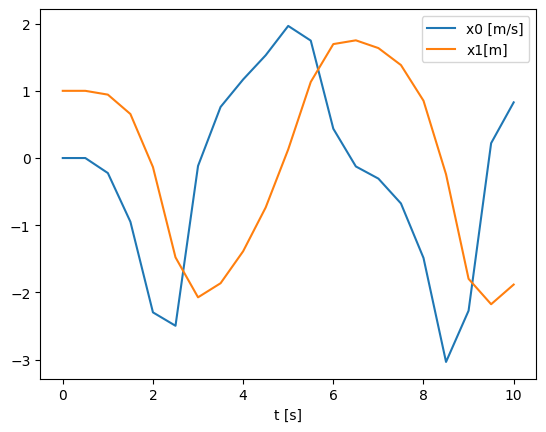

In [11]:
import matplotlib.pyplot as plt
res = sim(x0,cos(range(0,N)))
t = np.linspace(0, T, N+1)
# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((2,1)), res.toarray()), axis=1).T)
plt.legend(['x0 [m/s]', 'x1[m]'])
plt.xlabel('t [s]')
plt.show()

<h1>symbolic differentiation</h1>

In [12]:
U = MX.sym('U',N);

X1 = sim(x0, U)[0,:] #Simulate using concrete x0 and symbolic input series

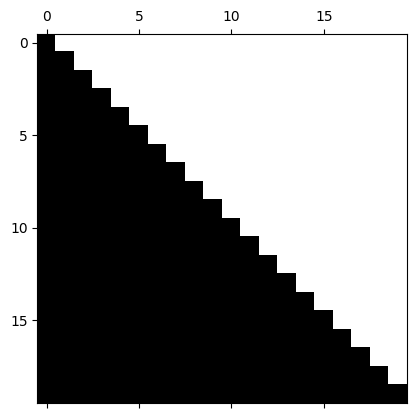

In [13]:
J = jacobian(X1, U) # jacobian of the first states wrt to input series

Jf = Function('Jf',[U],[J])
plt.spy(Jf(0))

<h1>Optimal control problem using multiple-shooting</h1>

In [128]:
opti = Opti() # Optimization problem

x = opti.variable(2,N+1) # decision variable for state trajectory
u = opti.variable(1,N)
p = opti.parameter(2,1) # parameter not optimized over

opti.minimize(sumsqr(x) + sumsqr(u)) 

for k in range(N):
    opti.subject_to(x[:,k+1]==F(x[:,k], u[:,k]))

opti.subject_to(u>=-1)
opti.subject_to(u<=1)
opti.subject_to(x[:,0]==p)

opti.solver('ipopt');

<h1>from opti (NLP modeling) to casadi functions</h1>

In [129]:
M = opti.to_function('M',[p],[u[:,0]], ['p'],['u_opt'])
M

Function(M:(p[2])->(u_opt) MXFunction)

In [130]:
opti.set_value(p,[0,1])
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

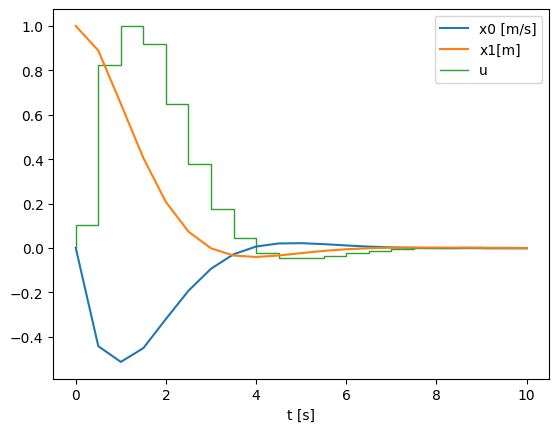

In [133]:
plt.figure()
plt.plot(t, sol.value(x).T)
plt.stairs(sol.value(u), t )
plt.legend(['x0 [m/s]', 'x1[m]', 'u'])
plt.xlabel('t [s]')
plt.show()

In [138]:
# MPC loop
import random


X_log = []
U_log = []

x = [0,1]
for i in range(0,4*N):
    u = M(x)
    
    U_log.append(float(u))
    X_log.append(x)
    
    # simulate system with noise
    x = [sum(c) for c in zip(F(x,u).toarray().flatten().tolist(), [0,random.uniform(0, 0.02)])]

X_log.append(x)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

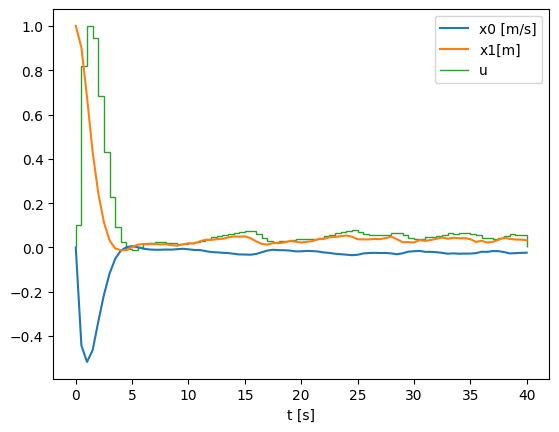

In [140]:
plt.figure()
tgrid_mpc = np.linspace(0, 4*T, 4*N+1)
plt.plot(tgrid_mpc, np.array(X_log))
plt.stairs(np.array(U_log), tgrid_mpc )
plt.legend(['x0 [m/s]', 'x1[m]', 'u'])
plt.xlabel('t [s]')
plt.show()

<h1>loading and saving function objects</h1>

In [142]:
M.save('M.casadi')

In [143]:
M2 = Function.load('M.casadi')

In [144]:
DM.set_precision(15)

In [145]:
M(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

DM(0.101897526480705)

In [147]:
M2(x0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

DM(0.101897526480705)

<h1>Code-generation with solver embedded</h1>

In [148]:
M.generate('codegen_demo', {'mex':True})


CasADi - 2023-10-22 01:28:48 WARNING("The function "solver", which is of type "IpoptInterface" cannot be code generated. The generation will proceed, but compilation of the code will not be possible.") [.../casadi/core/function_internal.cpp:2690]


'codegen_demo.c'